# CIS-522 Week 4 Homework


**Instructor:** Lyle Ungar

**Content Creator:** Rongguang Wang, Jordan Lei

---
## Preface
Since this week's homework requires coding, we recommend saving this notebook in your google Drive (`File -> Save a copy in Drive`), and share the link to the final version in the subscription airtable form. You can also attach the code to the form if you prefer off-colab coding.

In [19]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = 'jabrantl' #@param {type:"string"}
my_pod = 'superfluous-lyrebird' #@param ['Select', 'euclidean-wombat', 'sublime-newt', 'buoyant-unicorn', 'lackadaisical-manatee','indelible-stingray','superfluous-lyrebird','discreet-reindeer','quizzical-goldfish','ubiquitous-cheetah','nonchalant-crocodile','fashionable-lemur','spiffy-eagle','electric-emu','quotidian-lion','astute-jellyfish', 'quantum-herring']

# start timing
import time
try:t0;
except NameError: t0 = time.time()


# Setup

In [20]:
# imports
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset
import time
import math
import numpy as np
from bisect import bisect_right
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
# @title Figure Settings
import ipywidgets as widgets
%matplotlib inline 
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'
SMALL_SIZE = 12

plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title

# Part 1: Paper Reading

Please read the paper [ADAM: A METHOD FOR STOCHASTIC OPTIMIZATION](https://arxiv.org/pdf/1412.6980.pdf) and answer the following questions. 
Note that the paper is in some ways beyond the scope of this course. You can skip most of the details (and all of the proofs) in the paper. Just look at it enough to answer the following questions.

In [94]:
#@markdown **Student response**: The paper says that “Some of Adam’s advantages are that, 1) its stepsizes are approximately bounded by the stepsize hyperparameter, 2) it does not require a stationary objective, 3)it works with sparse gradients, and 4) it naturally performs a form of step size annealing“. Please rephrase each of these claims,  to make sure you understand what they mean.
rephrase_1 = 'The step size is scaled by the term m_t/v_t (assuming e = 0), which results in a step size smaller than the step size, alpha.' #@param {type:"string"}
rephrase_2 = 'In general, an objective function is stochastic if we are optimizing over a subset of the full population density, i.e. our training samples. In the case of SGD, ADAM, etc. our training samples are changing over time and thus our loss on these training samples is changing over time. This introduces stochasticity. In addition, it is possible that the noise can arise from within the function approximation.' #@param {type:"string"}
rephrase_3 = 'Sparse gradients are those in which the weight changes are zero or nearly zero w/o parameters being optimal. ADAM allows for memory of past gradients but requires longer memory when the gradients are sparse to get a true estimate of the average. However, without correction, the learning rate can be very large and result in divergence.' #@param {type:"string"}
rephrase_4 = 'As in 1, since the step size is scaled by the term m_t/v_t (assuming e = 0), the step size is always less than alpha. As the params approach an optimum, the scaling term --> 0, causing the learning rate to be annealed automatically. ' #@param {type:"string"}


In [95]:
#@markdown **Student response**: In the typical case, what is the bound on the update to the weights, \theta? (Hint: it’s just a simple hyperparameter)
bound = 'Except in the case of severe sparsity, the step size is abs(delta_t) \u003C alpha' #@param {type:"string"}

In [96]:
#@markdown **Student response**: What is “initialization bias correction”, and why is it needed?
bias_correction = 'Since the first and second moments, m_t and v_t, respectively, are initialized with zeros, they have a tendency to decay towards zero. Initialization bias correction prevents them from going to zero.' #@param {type:"string"}

In [97]:
#@markdown **Student response**: In English,  what is the “regret” in equation 5, and how does the regret scale with the number of stochastic gradient descent steps?
regret = 'Regret is the sum of the difference between the parameters and some ideal parameters. Because the ideal parameters and loss function are unknown, we can anticipate how different our ideal and estimated parameters using the regret term. ' #@param {type:"string"}

# Part 2: Cyclic Cosine Annealing

We have introduced many different variants of gradient descent for global minimum search such as Momentum, Adagrad, RMSProp, and Adam. These optimizers all follow their own pattern of finding this minimum loss by giving rules on how to adjust their step size, but what if we get stuck in a local minimum of a loss landscape? Even though some optimizers try and use ideas of momentum to have the ability to swing out of a local minimum, they are not always that successful.

<p align="center">
  <img width="500" height="200" src="https://miro.medium.com/max/1400/1*9Fca3kpx3pVW8SaYz2pjpw.png">
</p>

For example, the model in the left figure slowly descends into a local minimum, while the model in the right figure jumps in and out of several local minimums, searching for a more stable one.

One possible solution is cyclic cosine annealing. Instead of trying to add various forms of learning rate decay, let’s reset our learning rate every fixed iterations so that we might be able to more easily pop out of a local minimum. Specifically, we simulate a restart of SGD once $T_i$ epochs are performed, where $i$ is the index of the run. The learning rate update rule within the $i$-th run is:
$$\eta_t=\eta^i_{min}+\frac{1}{2}(\eta^i_{max}-\eta^i_{min})(1+\cos(\frac{T_{cur}}{T_i}\pi))$$
where
*   $\eta^i_{min}$ and $\eta^i_{max}$ are the range of the learning rate;
*   $T_{cur}$ is the count of epoch since last restart;
*   $T_i$ is the width between the two restarts.

<p align="center">
  <img width="300" height="200" src="https://miro.medium.com/max/1400/1*GjdEoZcEcQF19JS1y8nVYw.png">
</p>

The above figure shows an example of cyclic consine annealing. For more details, check out this [paper](https://arxiv.org/pdf/1608.03983.pdf).

You will implement a cyclic cosine annealing learning rate schedueler to perform digit classification. Towards this goal, you have to perform the following steps:

1. Define a cyclic consine annealing function which restarts the learning rate at two milestones (5 and 10 in this case). Insert your code in the cell below.

   Hint: Modify the learning rate using below code.
   ```python
    for param_group in optimizer.param_groups: 
        param_group[’lr’] = lr
   ```

In [71]:
def cyclic_cosine_annealing(optimizer, milestones=[0,5,10,20], eta_min=1e-6, last_epoch=0,eta_max=1e-2):
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    # raise NotImplementedError("Add the missing code")
    ####################################################################  
    import bisect
    print("last epoch: ", last_epoch)
    if last_epoch in milestones:
          # Set rate to max value
          lr = eta_max
    else:
        # Get index of epoch value in milestones list
        idx = bisect.bisect_left(milestones, last_epoch)
        # Compute width between last resets
        width = milestones[idx] - milestones[idx - 1] - 1
        # Get current epoch
        T_cur = last_epoch - milestones[idx-1]
        # Compute lr using cosine annealing
        lr = eta_min + 0.5*(eta_max - eta_min)*(1 + np.cos((T_cur/width)* np.pi))
        print("Epoch since last reset: ", T_cur, "width: ", width)

    for param_group in optimizer.param_groups: 
        param_group['lr'] = lr
        

    
    ####################################################################  

2. Check the learning rate computed by the scheduler you just implemented using the code below. Make sure that you observe behavior similar to that in the above figure. 

last epoch:  0
last epoch:  1
Epoch since last reset:  1 width:  4
last epoch:  2
Epoch since last reset:  2 width:  4
last epoch:  3
Epoch since last reset:  3 width:  4
last epoch:  4
Epoch since last reset:  4 width:  4
last epoch:  5
last epoch:  6
Epoch since last reset:  1 width:  4
last epoch:  7
Epoch since last reset:  2 width:  4
last epoch:  8
Epoch since last reset:  3 width:  4
last epoch:  9
Epoch since last reset:  4 width:  4
last epoch:  10
last epoch:  11
Epoch since last reset:  1 width:  9
last epoch:  12
Epoch since last reset:  2 width:  9
last epoch:  13
Epoch since last reset:  3 width:  9
last epoch:  14
Epoch since last reset:  4 width:  9
last epoch:  15
Epoch since last reset:  5 width:  9
last epoch:  16
Epoch since last reset:  6 width:  9
last epoch:  17
Epoch since last reset:  7 width:  9
last epoch:  18
Epoch since last reset:  8 width:  9
last epoch:  19
Epoch since last reset:  9 width:  9


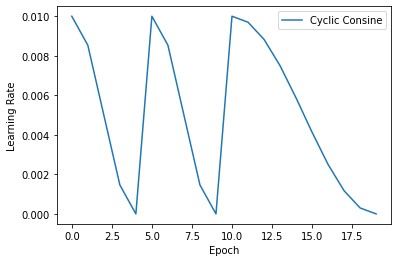

In [72]:
model = torch.nn.Linear(2, 1)
optimizer = optim.SGD(model.parameters(), lr=1e-2)

lr_list = []
for i in range(20):
    cyclic_cosine_annealing(optimizer, last_epoch=i)
    lr_list.append(optimizer.param_groups[0]['lr'])
    optimizer.step()

#with plt.xkcd():
plt.plot(range(20), lr_list, label='Cyclic Consine')
plt.ylabel('Learning Rate')
plt.xlabel('Epoch')
plt.legend()
plt.show()

3. Train a digit classifier on MNIST using your cyclic cosine annealing scheduler. We provide the training code below.

In [73]:
# @title MNIST Classifier (run me)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    avg_loss = 0.
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        avg_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    avg_loss /= len(train_loader.dataset)
    return avg_loss

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 1. - correct / len(test_loader.dataset)

def main(args):
    # gpu configuration
    use_cuda = not args['no_cuda'] and torch.cuda.is_available()
    torch.manual_seed(args['seed'])
    device = torch.device('cuda' if use_cuda else 'cpu')
    # data loader configuration
    train_kwargs = {'batch_size': args['batch_size']}
    test_kwargs = {'batch_size': args['test_batch_size']}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    # load MNIST dataset
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True,
                       transform=transform),**train_kwargs)
    test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False,
                       transform=transform), **test_kwargs)
    # init models
    model = Net().to(device)
    # config optimizer
    optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
    # training and testing
    train_list, test_list = [], []
    for epoch in range(1, args['epochs'] + 1):
        if args['scheduler']:
            cyclic_cosine_annealing(optimizer, last_epoch=epoch-1)
        loss = train(args, model, device, train_loader, optimizer, epoch) # train
        train_list.append(loss)
        error = test(model, device, test_loader) # test
        test_list.append(error)

    return train_list, test_list

4. Run the below code to train the network.  Compare the training and testing error of SGD and SGD with cyclic cosine annealing learning rate.

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.372480
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.291658
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.386771
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.419221
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.290317
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.311185
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.204825
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.326147
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.344783
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.358334

Test set: Average loss: 0.1842, Accuracy: 9437/10000 (94.3700%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.212907
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.288268
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.201828
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.327519
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.214356
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.339388
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.119330
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.298817
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.206

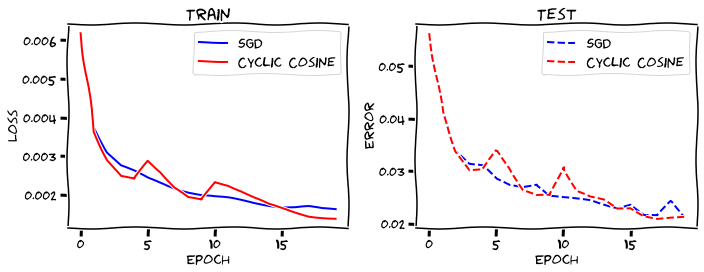

In [74]:
# @title Train and Plot (run me)
# Training settings
args = {'batch_size': 64,
        'test_batch_size': 1000,
        'epochs': 20,
        'lr': 0.01,
        'scheduler': False,
        'momentum': 0.9,
        'net_type': 'Net',
        'no_cuda': False,
        'seed': 1,
        'log_interval': 100
        }

lr_anneal = [False, True]
loss_dict = {}

for i in range(len(lr_anneal)):
    args['scheduler'] = lr_anneal[i]
    train_loss, test_error = main(args)
    loss_dict['train' + str(lr_anneal[i])] = train_loss
    loss_dict['test' + str(lr_anneal[i])] = test_error

with plt.xkcd():
    fig, axs = plt.subplots(1, 2, figsize=(10,4))
    axs[0].plot(loss_dict['trainFalse'], label='SGD', color='b')
    axs[1].plot(loss_dict['testFalse'], label='SGD', color='b', linestyle='dashed')
    axs[0].plot(loss_dict['trainTrue'], label='Cyclic Cosine', color='r')
    axs[1].plot(loss_dict['testTrue'], label='Cyclic Cosine', color='r', linestyle='dashed')
    axs[0].set_title('Train')
    axs[1].set_title('Test')
    axs[0].set_ylabel('Loss')
    axs[1].set_ylabel('Error')
    axs[0].set_xlabel('Epoch')
    axs[1].set_xlabel('Epoch')
    axs[0].legend()
    axs[1].legend()
    plt.tight_layout()
    plt.show()

# Part 3: Stochastic Weight Averaging (SWA) Optimizer

In this section, you'll implement a new optimizer to perform digit classification in the MNIST dataset.

<p align="center">
  <img width="800" height="200" src="https://miro.medium.com/max/2000/1*_USiR_z8PKaDuIcAs9xomw.png">
</p>

The intuition for SWA comes from the empirical observation that local minima tend to accumulate at the border of areas on loss surface where the loss value is low (points $W_1$, $W_2$ and $W_3$ are at the border of the red area of low loss in the left panel of figure above). By taking the average of several such points, it is possible to achieve a wide, generalizable solution with even lower loss ($W_{SWA}$ in the left panel of the figure above).

Here is how it works. Instead of an ensemble of many models, you only need two models:

$$w_{SWA}\leftarrow \frac{w_{SWA}\cdot n_{models}+w}{n_{models}+1}$$

*   The first model stores the running average of model weights ($w_{SWA}$ in the above formula). This will be the final model after the end of the training, and will be used for predictions.
*   The second model ($w$ in the formula) will be traversing the weight space.

At the end of each training epoch, the current weights of the second model will be used to update the weight of the running average model by taking the weighted mean between the old running average weights and the new set of weights from the second model.(See formula above.) By following this approach, we only need to train one model, and store only two models in memory during training. For prediction, we only need the running average model.

Here is the pseudo code of the algorithm:
  ```python
    # Algorithm: Stochastic Weight Averaging

    Require: Weight w_hat, learning rate lr, epochs n
    Initialize with w <- w_hat and w_swa <- w
    for i = 1, 2,..., n do
        w <- w - lr * d(L_i)/dw
        n_models <- i
        w_swa <- (w_swa * n_models + w) / (n_models + 1)
    end for
    Output: w_swa
  ```
<p align="center">
  <img width="450" height="250" src="https://pytorch.org/assets/images/swapytorch4.png">
</p>

We expect solutions that are centered in the flat region of the loss to generalize better than those near the boundary. Indeed, train and test error surfaces are not perfectly aligned in the weight space. Solutions that are centered in the flat region are not as susceptible to the shifts between train and test error surfaces as those near the boundary. In the figure above, the train and test error surfaces along the direction connecting the SWA and SGD solutions. As you can see, while the SWA solution has a higher training loss than the SGD solution, it is centered in a region of low loss and has a substantially better test error. To see more details about SWA, check the [paper](https://arxiv.org/pdf/1803.05407.pdf).
  

You will implement SWA to perform digit classification. Towards this goal, you have to perform the following steps:

1. Define a neural network to digit classification (provided).

In [75]:
# @title Network Class (run me)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

2. Implement training and testing procedures (provided).

In [76]:
# @title Train and Test functions (run me)
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    avg_loss = 0.
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        avg_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    avg_loss /= len(train_loader.dataset)
    return avg_loss

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 1. - correct / len(test_loader.dataset)

3. Define the SWA moving average function. Insert your code in the cell below.

In [87]:
def moving_average(model, swa_model, swa_n):
    for param, param_swa in zip(model.parameters(), swa_model.parameters()):
        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        # raise NotImplementedError("Add the missing code")
        ####################################################################  
        param_swa.data *= swa_n
        param_swa.data += param.data
        param_swa.data /= swa_n + 1

        ####################################################################  

4. Load the MNIST dataset from torchvision, initialize models, optimizers, and learning rate schedueler (provided).

5. Finish the SWA update rule. Insert your code in the cell below.

In [88]:
def main(args):
    # gpu configuration
    use_cuda = not args['no_cuda'] and torch.cuda.is_available()
    torch.manual_seed(args['seed'])
    device = torch.device('cuda' if use_cuda else 'cpu')
    # data loader configuration
    train_kwargs = {'batch_size': args['batch_size']}
    test_kwargs = {'batch_size': args['test_batch_size']}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    # load MNIST dataset
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True,
                       transform=transform),**train_kwargs)
    test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False,
                       transform=transform), **test_kwargs)
    # init models
    model = Net().to(device)
    swa_model = Net().to(device) # new introduced model!
    swa_n = 0
    # config optimizer and learnng rate scheduler
    optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
    scheduler = StepLR(optimizer, step_size=1, gamma=args['gamma'])
    # training and testing
    train_list, test_list, swa_list = [], [], []
    for epoch in range(1, args['epochs'] + 1):
        loss = train(args, model, device, train_loader, optimizer, epoch) # train
        train_list.append(loss)
        error = test(model, device, test_loader) # test
        test_list.append(error)
        # swa update rule
        if epoch >= args['swa_start']:
            ####################################################################
            # Fill in missing code below (...),
            # then remove or comment the line below to test your function
            # raise NotImplementedError("Add the missing code")
            ####################################################################  
            moving_average(model, swa_model, epoch-args['swa_start'])
  
            
            ####################################################################
        swa_error = test(swa_model, device, test_loader) # test swa
        swa_list.append(swa_error)
        scheduler.step()

    return train_list, test_list, swa_list

6. Starting training and testing. Then plot the training loss and testing error comparison between SGD and SWA using the code provided.
  **Note**: we might not be able to observe an expected performance of SWA, since MNIST calssification is relatively a simple task compared to CIFAR-10 / CIFAR-100. 

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.337618
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.332895
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.291659
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.223955
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.283067
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.382178
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.152357
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.358896
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.335750
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.348926

Test set: Average loss: 0.1828, Accuracy: 9418/10000 (94.1800%)


Test set: Average loss: 2.3268, Accuracy: 1242/10000 (12.4200%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.228242
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.313276
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.212165
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.304948
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.213057
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.271722
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.215826
Train Epoch: 2 [44800/60000 (7

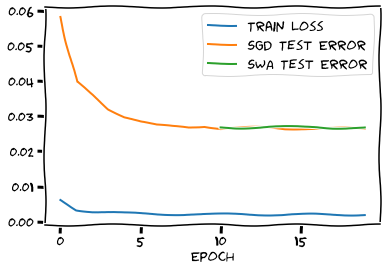

In [89]:
# @title Train and Plot (run me)
# Training settings
args = {'batch_size': 64,
        'test_batch_size': 1000,
        'epochs': 20,
        'swa_start': 10,
        'lr': 0.01,
        'momentum': 0.9,
        'gamma': 0.7,
        'net_type': 'Net',
        'no_cuda': False,
        'seed': 1,
        'log_interval': 100
        }

train_loss, test_error, swa_error = main(args)

with plt.xkcd():
    plt.plot(train_loss, label='Train Loss', linewidth=2)
    plt.plot(test_error, label='SGD Test Error', linewidth=2)
    plt.plot(range(10, 20), swa_error[10:], label='SWA Test Error', linewidth=2)
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# Part 4: Better-Know-A-Pod
*This section is designed to let you better know your pod mates. You are encouraged to discuss these with your pod mates during pod sessions or during pod social events, but NOT over Slack. The idea is to get to know your pod mates face-to-face.*

**List 2 other members of your pod and write a thoughtful and nice short blurb about them (around 100 words each). Where are they from? What do they study? What are their hobbies? What do you have in common?**



In [102]:
better_know_a_pod = '''
Joseph Goodman: Joseph is a MS in Data Science student who submatriculated from another program. He has a job lined up with a financial firm
in Wall Street after graduating. He is looking forward to starting the position. He expressed some interest in doing a PhD but says he wants to 
go into industry for a while so he can get some experience. He is from New Jersey. We have been in breakout rooms nearly every time and have spent quite a bit of time
discussing the notebooks in detail. 

Nicole Chiou: Nicole is from San Francisco and submatriculated into the MS in Data Science Program after studying Bioengineering. She is currently applying 
for PhD programs, including interest in Penn programs. She grew up playing music (violin, piano) and originally wanted to attend University for music. She is currently
doing research in a medical lab where she is using deep learning models to create invidualized medical device settings used for the heart. 
'''

# Submission
Double check that the answers have been correctly formatted in the Airtable below, and edit them as desired. **In addition to submitting the form, contribute and reflect on these readings in the student Slack space.**

In [101]:
#@markdown #Run Cell to Show Airtable Form
#@markdown ##**Confirm your answers and then click "Submit"**
import numpy as np
import time
from IPython.display import IFrame
def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefills = "&".join(["prefill_%s=%s"%(key, fields[key]) for key in fields])
  src = src + prefills
  src = "+".join(src.split(" "))
  return src

#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""
try: my_pod;
except NameError: my_pod = "Select"
try: rephrase_1;
except NameError: rephrase_1 = ""
try: rephrase_2;
except NameError: rephrase_2 = ""
try: rephrase_3;
except NameError: rephrase_3 = ""
try: rephrase_4;
except NameError: rephrase_4 = ""
try: bound;
except NameError: bound = ""
try: bias_correction;
except NameError: bias_correction = ""
try: regret;
except NameError: regret = ""
try: better_know_a_pod;
except NameError: better_know_a_pod = ""


#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()
try: t1;
except NameError: t1 = time.time()
times = np.array([t1])-t0

fields = {"pennkey": my_pennkey,
          "pod": my_pod,
          "rephrase_1":rephrase_1,
          "rephrase_2":rephrase_2,
          "rephrase_3":rephrase_3,
          "rephrase_4":rephrase_4,
          "bound":bound,
          "bias_correction":bias_correction,
          "regret":regret,
          "better_know_a_pod": better_know_a_pod,
          "cumulative_times": times}

src = "https://airtable.com/embed/shrN8MK580CBFiGCu?"

#now instead of the original source url, we do: src = prefill_form(src, fields)
display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))